In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

from scipy import signal
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

import cmocean.cm as cmo

In [2]:
from dask.distributed import Client

client = Client()
client

/opt/miniconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:42114 Dashboard: http://127.0.0.1:44030/status,Cluster Workers: 8 Cores: 32 Memory: 67.28 GB


## Test spectral width of a three period filter.

In order to examine how broad a frequency a three-period filter will select, create a three-period wave buffered by zeros, and analyze the power spectrum

In [3]:
t = np.linspace(0, 100, 2401)  # 100 day long timeseries.
f = 1.0                        # cycles per day

Create a long timeseries with exactly three cycles to test the spectral properties of a three cycle filter.

In [4]:
u = np.sin(2*np.pi*t*f)        # property with diurnal variability...
u[24*3:] = 0.                  # ...but only for the first three days.?

Plot and check to make sure there are no discontinuities.

(0, 5)

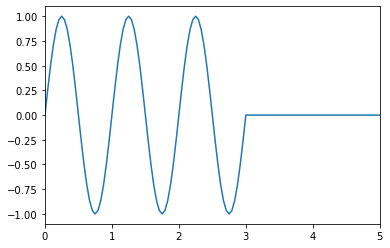

In [5]:
plt.plot(t, u)
plt.xlim(0, 5)

Calculate and plot a spectrum

In [6]:
freq, Pxx = signal.periodogram(u, 24.)

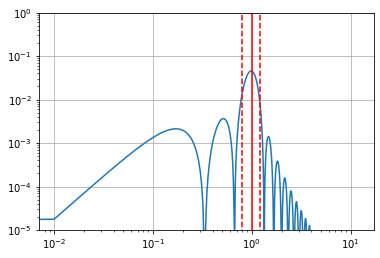

In [7]:
df = 0.2
plt.loglog(freq, Pxx)
plt.plot([1, 1], [1e-20, 1], '-r')
plt.plot([1.0+df, 1.0+df], [1e-20, 1], '--r')    # Plot dashed lines 1+/-df (Roughly f +/- 20%)
plt.plot([1.0-df, 1.0-df], [1e-20, 1], '--r')
plt.ylim(1e-5, 1)
plt.grid(True)

## Get three days worth of surface data, and calculate the amplitude of the near-inertial energy

Select a period from the proposal figure

In [8]:
proj = ccrs.LambertConformal(central_longitude=-92, central_latitude=29)
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k', facecolor='0.8')


In [9]:
ds = xr.open_mfdataset('/d2/shared/TXLA_ROMS/output_20yr_obc/2010/ocean_his_*.nc', chunks={'ocean_time': 1})

/opt/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/opt/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


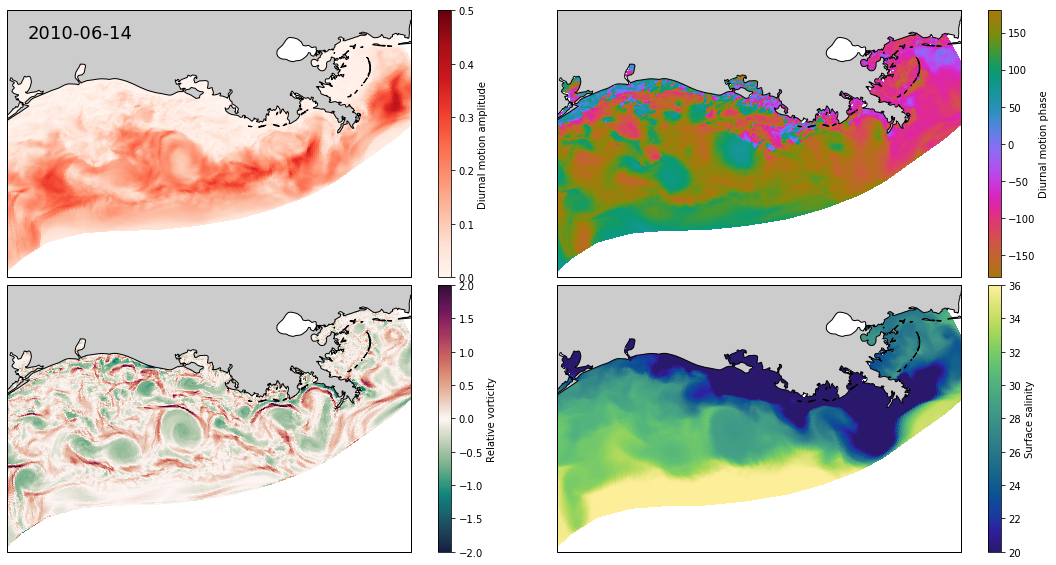

In [29]:
#select time range and specify surface values
def plot_niw_stuff(day):
    start_date = '2010-06-{day:02d}'.format(day=day)
    end_date = '2010-06-{day:02d}'.format(day=day+3)

    dss = ds.sel(ocean_time=slice(start_date, end_date)).isel(s_rho=-1)

    u = dss.u.values
    v = dss.v.values

    pm = ds.pm[0].values
    pn = ds.pn[0].values

    pm = 0.25*(pm[1:, 1:]+pm[:1, :-1]+pm[:-1, 1:]+pm[:-1, :-1])
    pn = 0.25*(pn[1:, 1:]+pn[:1, :-1]+pn[:-1, 1:]+pn[:-1, :-1])

    vort = (v[:, :, 1:]-v[:, :, :-1]).mean(axis=0)*pm - (u[:, 1:, :]-u[:, :-1, :]).mean(axis=0)*pn

    up = 0.5*(u[:, 1:, :]+u[:, :-1, :])
    vp = 0.5*(v[:, :, 1:]+v[:, :, :-1])

    fd = 2*np.pi/86400.0 # exactly diurnal

    dt = 3600.0                          # 1 hour in seconds
    t = np.arange(up.shape[0])*3600.0     # create time array in seconds
    Ui = np.sum(up * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
    Vi = np.sum(vp * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
    Ai = Ui + Vi

    phase = np.angle(Ai)

    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(221, projection=proj)
    pcA = ax1.pcolormesh(ds.lon_psi, ds.lat_psi, np.abs(Ai), 
                         cmap=plt.cm.Reds, transform=ccrs.PlateCarree(), vmin=0, vmax=0.5)
    ax1.add_feature(coast_10m)
    ax1.set_extent([-95, -88.25, 26.75, 30.75], ccrs.PlateCarree())
    plt.colorbar(pcA).set_label('Diurnal motion amplitude')
    ax1.text(0.05, 0.95, start_date, fontsize=18,
             horizontalalignment='left', verticalalignment='top', 
             transform=ax1.transAxes)

    ax2 = fig.add_subplot(222, projection=proj)
    pcp = ax2.pcolormesh(ds.lon_psi, ds.lat_psi, phase*180./np.pi, 
                         cmap=cmo.phase, transform=ccrs.PlateCarree(), vmin=-180, vmax=180)
    ax2.add_feature(coast_10m)
    ax2.set_extent([-95, -88.25, 26.75, 30.75], ccrs.PlateCarree())
    plt.colorbar(pcp).set_label('Diurnal motion phase')

    ax3 = fig.add_subplot(223, projection=proj)
    pcv = ax3.pcolormesh(ds.lon_psi, ds.lat_psi, vort/fd, 
                         cmap=cmo.curl, transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
    ax3.add_feature(coast_10m)
    ax3.set_extent([-95, -88.25, 26.75, 30.75], ccrs.PlateCarree())
    plt.colorbar(pcv).set_label('Relative vorticity')

    ax4 = fig.add_subplot(224, projection=proj)
    pcs = ax4.pcolormesh(ds.lon_rho, ds.lat_rho, dss.salt.values.mean(axis=0), 
                         cmap=cmo.haline, transform=ccrs.PlateCarree(), vmin=20, vmax=36)
    ax4.add_feature(coast_10m)
    ax4.set_extent([-95, -88.25, 26.75, 30.75], ccrs.PlateCarree())
    plt.colorbar(pcs).set_label('Surface salinity')

    plt.subplots_adjust(top=0.97, bottom=0.03, left=0.03, right=0.97, wspace=0.03, hspace=0.03)
    plt.savefig('niw_props_{day:04d}.png'.format(day=day))
#     plt.close(fig)

# for day in range(15, 27):
#     plot_niw_stuff(day)
#     print(day)

plot_niw_stuff(14)

In [25]:
day=15
start_date = '2010-06-{day:02d}'.format(day=day)
end_date = '2010-06-{day:02d}'.format(day=day+3)

dss = ds.sel(ocean_time=slice(start_date, end_date)).isel(s_rho=-1)

u = dss.u.values
v = dss.v.values

pm = ds.pm[0].values
pn = ds.pn[0].values

pm = 0.25*(pm[1:, 1:]+pm[:1, :-1]+pm[:-1, 1:]+pm[:-1, :-1])
pn = 0.25*(pn[1:, 1:]+pn[:1, :-1]+pn[:-1, 1:]+pn[:-1, :-1])

vort = (v[:, :, 1:]-v[:, :, :-1]).mean(axis=0)*pm - (u[:, 1:, :]-u[:, :-1, :]).mean(axis=0)*pn

up = 0.5*(u[:, 1:, :]+u[:, :-1, :])
vp = 0.5*(v[:, :, 1:]+v[:, :, :-1])

fd = 2*np.pi/86400.0 # exactly diurnal

dt = 3600.0                          # 1 hour in seconds
t = np.arange(up.shape[0])*3600.0     # create time array in seconds
Ui = np.sum(up * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Vi = np.sum(vp * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Ai = Ui + Vi

phase = np.angle((np.sqrt(2) + np.sqrt(2)*1j)*Ai)


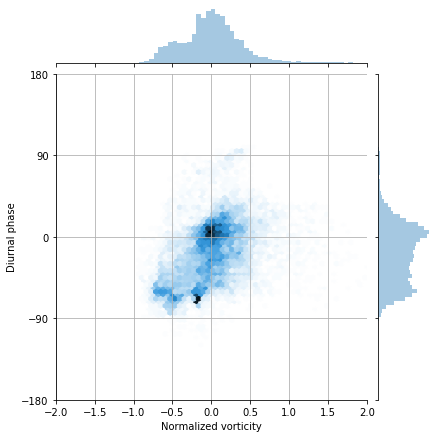

In [27]:
ph = -155 * np.pi / 180.0
phase = (180.0/np.pi)*(np.angle(Ai*np.exp(1j*ph)))

h = seaborn.jointplot(vort[25:125, 200:350].flatten()/fd, phase[25:125, 200:350].flatten(), kind='hex', 
                  xlim=(-2, 2), ylim=(-180, 180))

h.ax_joint.set_xlabel('Normalized vorticity')
h.ax_joint.set_ylabel('Diurnal phase')
h.ax_joint.set_yticks([-180, -90, 0, 90, 180])
h.ax_joint.grid(True)


# plt.plot(vort[25:125, 200:500].flatten()/fd, np.abs(Ai)[25:125, 200:500].flatten(), '.k', ms=0.5)
# plt.xlim(-1, 1)

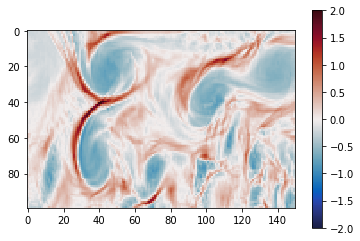

In [20]:
plt.imshow(vort[25:125, 200:350]/fd, cmap=cmo.balance, vmin=-2, vmax=2)
plt.colorbar()

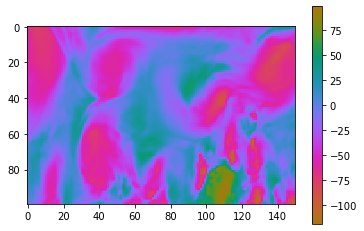

In [21]:
plt.imshow(phase[25:125, 200:350], cmap=cmo.phase)
plt.colorbar()

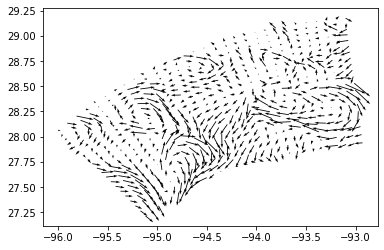

In [41]:
idx = 1

angle = 0.25*(ds.angle[0].values[1:, 1:]+ds.angle[0].values[:1, :-1]+
              ds.angle[0].values[:-1, 1:]+ds.angle[0].values[:-1, :-1])

ur = np.cos(angle)*up[idx] - np.sin(angle)*vp[idx]
vr = np.cos(angle)*vp[idx] + np.sin(angle)*up[idx]
plt.quiver(ds.lon_psi[25:125:5, 200:350:5], ds.lat_psi[25:125:5, 200:350:5],
           ur[25:125:5, 200:350:5], vr[25:125:5, 200:350:5])

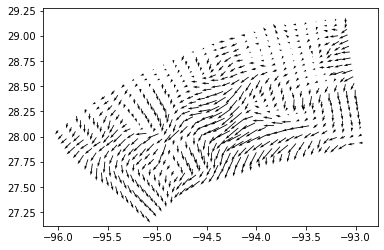

In [44]:
phi = 50*np.pi/180.
phase = np.exp(1j*phi)

ur = np.cos(angle)*np.real(Ui*phase) - np.sin(angle)*np.real(Vi*phase)
vr = np.cos(angle)*np.real(Vi*phase) + np.sin(angle)*np.real(Ui*phase)
plt.quiver(ds.lon_psi[25:125:5, 200:350:5], ds.lat_psi[25:125:5, 200:350:5],
           ur[25:125:5, 200:350:5], vr[25:125:5, 200:350:5])

In [62]:
dphase = (phase[:-1, :-1] + phase[1:, :-1] + phase[:-1, 1:] + phase[1:, 1:])

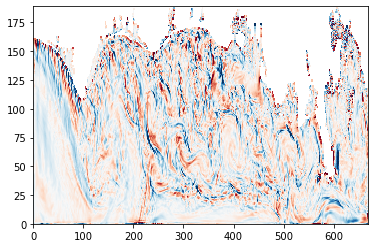

In [56]:
div = np.diff(u, axis=-1)[:, 1:-1, :] + np.diff(v, axis=-2)[:, :, 1:-1]
plt.pcolormesh(div.mean(axis=0), vmax=0.05, vmin=-0.05, cmap=plt.cm.RdBu_r)

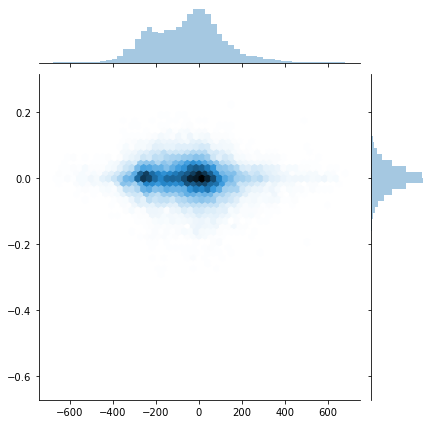

In [71]:
seaborn.jointplot(dphase[25:150, 200:450].flatten(), div[10][25:150, 200:450].flatten(), kind='hex')

In [ ]:
up = 0.5*(u[:, 1:, :]+u[:, :-1, :])
vp = 0.5*(v[:, :, 1:]+v[:, :, :-1])

fd = 2*np.pi/86400.0 # exactly diurnal

dt = 3600.0                          # 1 hour in seconds
t = np.arange(up.shape[0])*3600.0     # create time array in seconds
Ui = np.sum(up * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Vi = np.sum(vp * np.exp(-1J*fd*t[:, None, None]) * dt, axis=0)/t[-1]
Ai = Ui + Vi

phase = np.angle((np.sqrt(2) + np.sqrt(2)*1j)*Ai)

In [79]:
for i in range(div.shape[0]):
    plt.pcolormesh(div[i][25:150, 200:450], vmin=-0.1, vmax=0.1, cmap=plt.cm.RdBu_r)
    plt.savefig('fig_{i:04}'.format(i=i))
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [78]:
'fig_{i:04}'.format(i=10)

'fig_0010'